# Infer ***lysosome*** -  4️⃣

--------------

## OVERVIEW
In notesbooks 4 - 9, we will go how each organelle is segmented. These segmentation workflows are completely independent of each other and can be run in any order. Additionally, the entire image will be processed in this notebook, irrespective of the single cells identified in notebooks 1-3. The cell mask will be applied to the organelle segmentation outputs before quantification (as outlined in [10_regionprops](./10_regionprops.ipynb)). 

This notebook goes through the workflow steps to segment the ***lysosomes*** -- one of the six organelles of interest.

## OBJECTIVE: 
### ✅ Infer sub-cellular component ***lysosome***
Segment the ***lysosomes*** from a single channel (lysosome membrane marker). This workflow was optimized for images of fluorescently tagged Lamp1, a membrane protein. When lysosomes are larger in size, this causes a hollow sphere structure that requires different segmentation compared to smaller lysosomes that appear filled in.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.vessel import filament_2d_wrapper
from skimage.measure import label

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)
from infer_subc.core.img import * #dot_filter_3, filament_filter_3
from infer_subc.organelles import fixed_infer_cellmask_fromcomposite, fixed_infer_nuclei_fromlabel, get_cytoplasm, get_nuclei, get_cellmask
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )              

%load_ext autoreload
%autoreload 2


## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) /  "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


---------------------

## infer ***lysosomes***

## summary of steps

➡️ INPUT
- select single channel containing the lysosome marker (channel number = user input)

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)

CORE PROCESSING
- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)
- apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)
- combine the two segmentations with logical *OR*

POST-PROCESSING
  - fill holes (hole size = user input)
  - remove small objects (object size = user input)

OUTPUT ➡️
- label unique lysosome objects based on connectivity
- save labeled ***lysosomes*** (lyso, LS) as unsigned integer 16-bit tif files


> Generally, we followed the Allen Cell Segmenter procedure for lysosome segmentation from the [Lamp1](https://www.allencell.org/cell-observations/category/lamp1) marker. Sourced from: this notebook [example](https://github.com/AllenCell/aics-segmentation/blob/main/lookup_table_demo/playground_lamp1.ipynb)



## EXTRACT prototype

In [4]:
###################
# INPUT
###################
raw_lyso = select_channel_from_raw(img_data, LYSO_CH)

## PRE-PROCESSING prototype


In [5]:
###################
# PRE_PROCESSING
###################

med_filter_size = 3   
gaussian_smoothing_sigma = 1.34

struct_img =  scale_and_smooth(raw_lyso,
                               median_size = med_filter_size, 
                               gauss_sigma = gaussian_smoothing_sigma)

## CORE PROCESSING prototype

In [7]:
###################
# CORE_PROCESSING
###################
## PARAMETERS for this step ##
# s_param = [[5,0.09], [2.5,0.07], [1,0.01]]
dot_method = "3D"
################################
# apply the 2D or 3D versions of the AICSsegmentation dot filter with multiple scales
bw_dot_test = dot_filter_3(struct_img, 5, 0.09, 2.5, 0.07, 1, 0.01, dot_method)


################################
## PARAMETERS for this step ##
# f_param = [[1, 0.15]]
fil_method = "3D"
################################
bw_filament_test = filament_filter_3(struct_img, 1, 0.15, 0,0,0,0, fil_method)


# combine the two segmentations together
bw_test = np.logical_or(bw_dot_test, bw_filament_test)


### POST-PROCESSING

In [8]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 25

small_object_width = 0

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)


## LABELING prototype

In [9]:
lysosome_labels = label_uint16(cleaned_img2)

In [10]:
lysosome_labels.dtype

dtype('uint16')

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [11]:
viewer = napari.Viewer()

30-May-23 18:11:02 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x687+1289-551 (frame: 1112x743+1278-596) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY3". Resulting geometry: 1224x1106+1289-551 (frame: 1246x1162+1278-596) margins: 11, 45, 11, 11 minimum size: 612x590 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=1246,1236 maxtrack=0,0)
30-May-23 18:11:02 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1224x1274+1630+1068 (frame: 1242x1321+1621+1030) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1020x1061+1628+1061 (frame: 1038x1108+1619+1023) margins: 9, 38, 9, 9 minimum size: 612x594 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,641 maxtrack=0,0)


In [12]:
viewer.add_image(
    raw_lyso)    

viewer.add_image(
    cleaned_img2,
    opacity=0.3,)

viewer.add_labels(
    lysosome_labels,
    opacity=0.3)

<Labels layer 'lysosome_labels' at 0x16a183f5de0>

## SAVE inferred lysosomes to .tif file

In [13]:
out_file_n = export_inferred_organelle(lysosome_labels, "lyso", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-lyso


----------
## DEFINE `_infer_lysosomes` function

Based on the _prototyping_ above define the function to infer nuclei. 

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [14]:
##########################
#  infer_LYSOSOMES
##########################
def _infer_lyso(
                                in_img: np.ndarray,
                                lyso_ch: int,
                                median_sz: int,
                                gauss_sig: float,
                                dot_scale_1: float,
                                dot_cut_1: float,
                                dot_scale_2: float,
                                dot_cut_2: float,
                                dot_scale_3: float,
                                dot_cut_3: float,
                                dot_method: str,
                                fil_scale_1: float,
                                fil_cut_1: float,
                                fil_scale_2: float, 
                                fil_cut_2: float, 
                                fil_scale_3: float, 
                                fil_cut_3: float,
                                fil_method: str,
                                min_hole_w: int,
                                max_hole_w: int,
                                small_obj_w: int,
                                fill_filter_method: str
                            ) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    fil_scale: 
        scale (log_sigma) for filament filter
    fil_cut: 
        threshold for filament fitered threshold
    min_hole_w: 
        hole filling min for nuclei post-processing
    max_hole_w: 
        hole filling cutoff for nuclei post-processing
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    fill_filter_method:
        to fill snall holes and remove small objects in "3D" or "slice-by-slice"

    Returns
    -------------
    lyso_object
        mask defined extent of lysosome object

    """
    ###################
    # EXTRACT
    ###################    
    lyso = select_channel_from_raw(in_img, lyso_ch)

     ###################
    # PRE_PROCESSING
    ###################    
    lyso1 =  scale_and_smooth(lyso,
                             median_size = median_sz, 
                             gauss_sigma = gauss_sig)
   ###################
    # CORE_PROCESSING
    ###################
    bw_dot = dot_filter_3(lyso1, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw_filament = filament_filter_3(lyso1, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    bw = np.logical_or(bw_dot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, hole_min=min_hole_w, hole_max=max_hole_w, min_size=small_obj_w, method=fill_filter_method)

    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


## DEFINE `_fixed_infer_lyso` function


In [15]:
##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_lyso(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input with *fixed parameters*
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    lyso_object
        mask defined extent of NU
    """
    lyso_ch = 1
    median_sz = 3
    gauss_sig = 1.34
    dot_scale_1 = 5
    dot_cut_1 = 0.09
    dot_scale_2 = 2.5
    dot_cut_2 = 0.07
    dot_scale_3 = 1
    dot_cut_3 = 0.01
    dot_method = "3D"
    fil_scale_1 = 1
    fil_cut_1 = 0.15
    fil_scale_2 = 0
    fil_cut_2 = 0
    fil_scale_3 = 0
    fil_cut_3 = 0
    fil_method = "3D"
    min_hole_w = 0
    max_hole_w = 25
    small_obj_w = 0
    method = "3D"

    return _infer_lyso(  
        in_img,
        lyso_ch,
        median_sz,
        gauss_sig,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2,
        dot_scale_3,
        dot_cut_3,
        dot_method,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        min_hole_w,
        max_hole_w,
        small_obj_w,
        method)

# TEST `_infer_lyso` function defined above

In [16]:
_lyso_object =  _fixed_infer_lyso(img_data) 

_lyso_object.dtype

dtype('uint16')

In [17]:
np.all(lysosome_labels == _lyso_object)

True

---------------------
# TEST `infer_lyso` exported functions

The prototype `_infer_lyso` was copied to the [`.organelles.lysosome`](../infer_subc/organelles/lysosome.py) sub-module.

In [18]:
from infer_subc.organelles.lysosome import fixed_infer_lyso

lyso_object =  fixed_infer_lyso(img_data)

In [19]:
np.all(_lyso_object == lyso_object)

True

## Visualize  2


In [20]:
viewer.add_image(
    _lyso_object,
    opacity=0.3)

viewer.add_labels(
    lyso_object,
    opacity=0.3)

<Labels layer 'lyso_object' at 0x16a82be6e30>

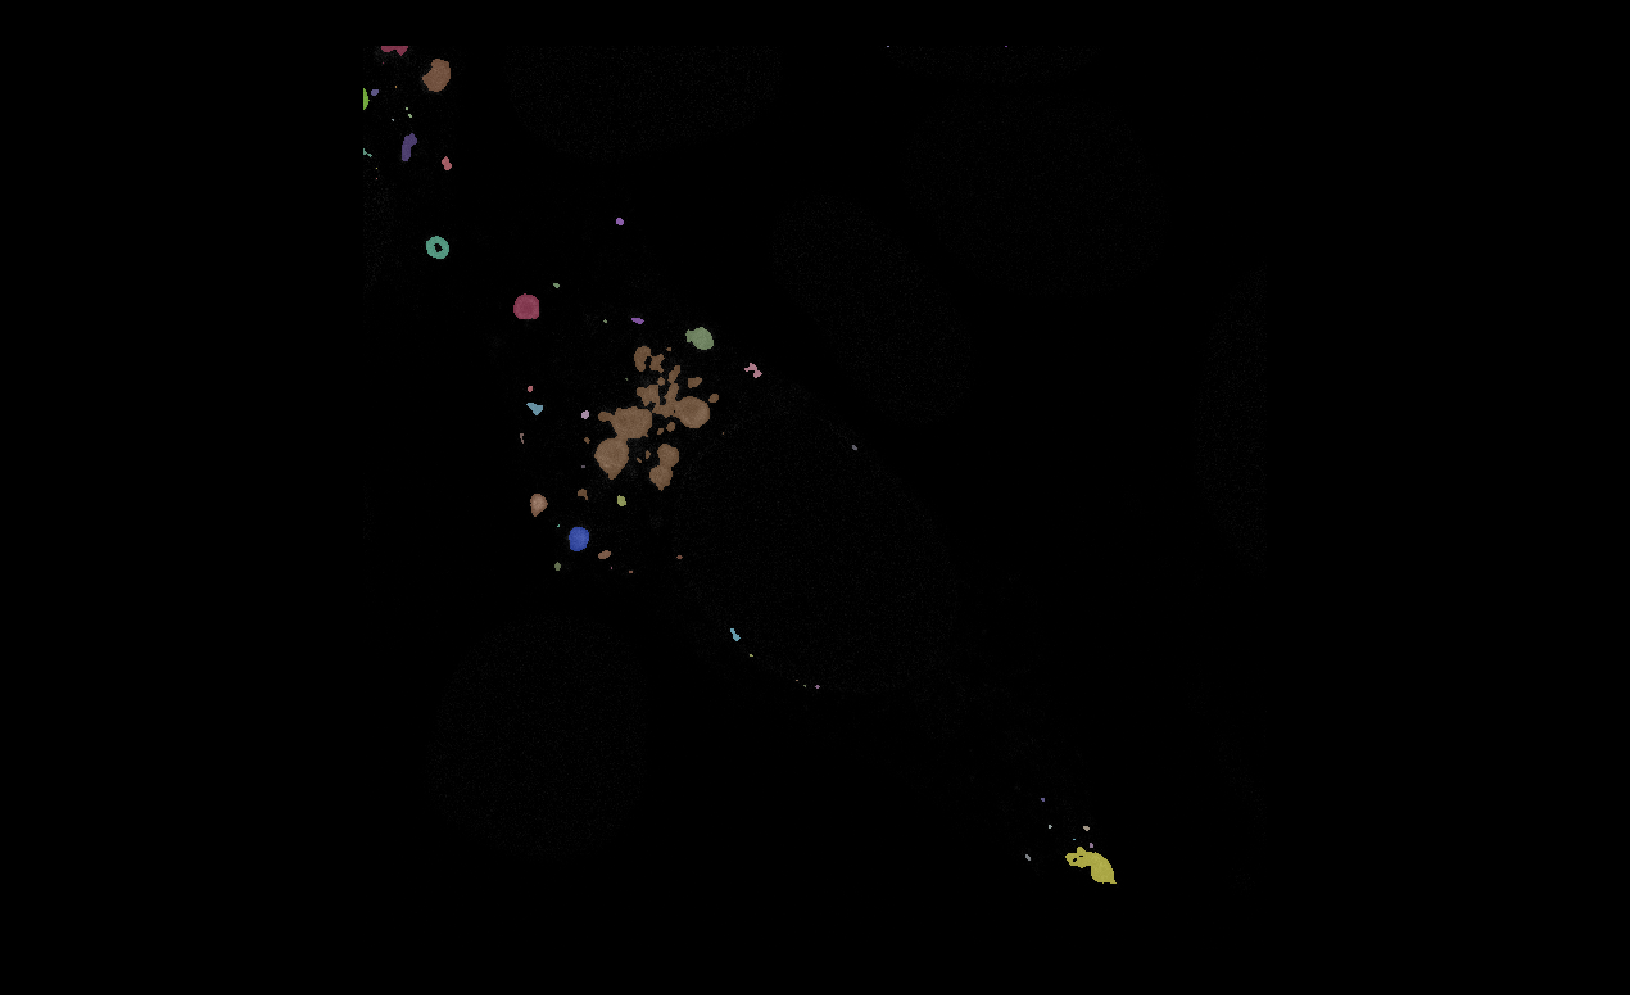

In [21]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [22]:
viewer.close()

-------------
## SUMMARY

The above details how the lysosome object is inferred.  

### NEXT: INFER MITOCHONDRIA

proceed to [05_infer_mito.ipynb](./05_infer_mito.ipynb)
